In [2]:
import requests
from pathlib import Path

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

In [3]:
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


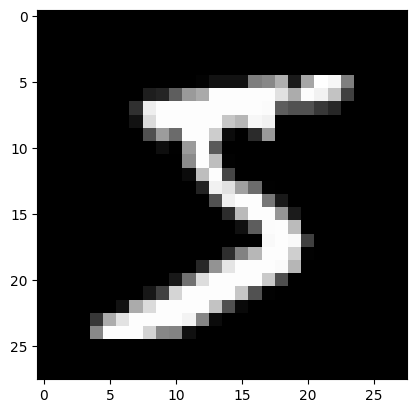

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [9]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)
# the preds tensor contains not only the tensor values, but also a gradient function

tensor([-2.2739, -2.3975, -2.4975, -2.7287, -1.9482, -2.2329, -2.5314, -2.3012,
        -2.5342, -1.8985], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [10]:
# Predictions have shape (64,10) and for each image we want to select only the true class
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4131, grad_fn=<NegBackward0>)


In [12]:
def accuracy(out, yb):
    # From (64, 10) -> (64) to classify each image
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [13]:
print(accuracy(preds, yb))

tensor(0.0156)


In [14]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        """
        These action should not be included for the calculation of gradient
        The gradient must take into account only the computations for the predictions
        """
        with torch.inference_mode():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_() # Set the gradient to zero
            bias.grad.zero_()

In [15]:
preds = model(x_valid)
print(accuracy(preds, y_valid))

tensor(0.9182)


We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible. At each step from here, we should be making our code one or more of:
* shorter
* more understandable
* more flexible.

### 1. Activation and Loss Functions
Use those coming from `torch.nn.functional` imposed as `F` by convention

In [16]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb @ weights + bias

### 2. Coincise Training Loop
Create a class that holds parameters and the forward pass. This is done by creating a subclass of `nn.Module`

In [17]:
from torch import nn

class MNIST_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self. weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias

In [ ]:
model = MNIST_Logistic()

In [ ]:
print(loss_func(model(xb), yb))

tensor(2.3050, grad_fn=<NllLossBackward0>)


In [18]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()

            with torch.no_grad():
                for p in model.parameters(): # Take advantage of parameters attribute from nn.Module
                    p -= p.grad * lr
                model.zero_grad() # Instead of parameter.grad.zero() for each parameter

In [ ]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward0>)


### 3. Refactor using a linear layer
Weights and biases are created and initialized automatically using `nn.Linear`, which takes also into account the forward pass

In [19]:
class MNIST_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784,10)

  def forward(self, xb):
    return self.lin(xb)

In [ ]:
torch.manual_seed(101)
model = MNIST_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3629, grad_fn=<NllLossBackward0>)


In [ ]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward0>)


### 4. Use an optimization algorithm
`torch.optim` contains several optimization algorithms and `opt.step()` computes the gradient descent for all parameters

In [20]:
from torch import optim

def get_model():
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.3139, grad_fn=<NllLossBackward0>)


In [ ]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward0>)


### 5. Dataset & DataLoader
PyTorch has an abstract `Dataset` class that can be anything with `__len__` and `__getitem__` functions. This is useful because combining dataset and target, each mini-batch is extracted from a Dataset. `TensorDataset` creates a Dataset by wrapping a tensor

`DataLoader` takes as parameter a `Dataset` and the batch-size such to return an iterable object that for each iteration returns a mini-batch data that:
* we don't have to calculate the number of mini-batch per epoch
* it can automatically shuffle data to present them in different mini-batch each epoch

In [21]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle = True)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0399, grad_fn=<NllLossBackward0>)


### 6. Add Validation
The validation loss is computed over mini-batch to avoid finishing RAM in a single batch. Batch-size for validation data can be higher because this step doesn't require backpropagation so less memory is involved

In [22]:
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
  # Training mode
  model.train()

  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()
  # Evaluation mode
  model.eval()
  with torch.inference_mode():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(f"Epoch {epoch}: {valid_loss/len(valid_dl)} loss")

Epoch 0: 0.30961158871650696 loss
Epoch 1: 0.29000940918922424 loss


### Further refactoring

In [23]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [24]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [25]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [26]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31487116620540617
1 0.35757911314964297


### CNN

In [36]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # view is PyTorch’s version of Numpy’s reshape
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1)) # [64, 10, 1, 1] -> [64, 10]

lr = 0.1

In [37]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [38]:
fit(1, model, loss_func, opt, train_dl, valid_dl)

0 0.34335631067752836


### Sequential
`nn.Sequential` is a subclass of `nn.Module` as a quicker way to create **sequential** NNs since it avoids defining `forward`

In [40]:
# OLD
class NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(10, 4)
        self.fc2 = nn.Linear(4, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

# NEW - extend nn.Sequential instead of nn.Module
class NN(nn.Sequential):
    def __init__(self):
        super().__init__(
           nn.Linear(10, 4),
           nn.ReLU(),
           nn.Linear(4, 2),
           nn.ReLU())

# Refactor - instantiate from nn.Sequential
model = nn.Sequential(
   nn.Linear(10, 4),
   nn.ReLU(),
   nn.Linear(4, 2),
   nn.ReLU())

`nn.Sequential` essentially becomes a container for a sequence of `nn.Module` objects: `nn.Linear`, `nn.Conv2d`... (which all extend `nn.Module`), while Tensor methods such as `view` aren't in this list so they are implemented through a `Lambda` layer

In [41]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [42]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3708558257579804
1 0.2683406547665596


In [44]:
model.eval()

# Disable gradient calculation (not needed for inference)
with torch.no_grad():
    # Forward pass: Get predictions
    output = model(x_valid)

tensor(3)


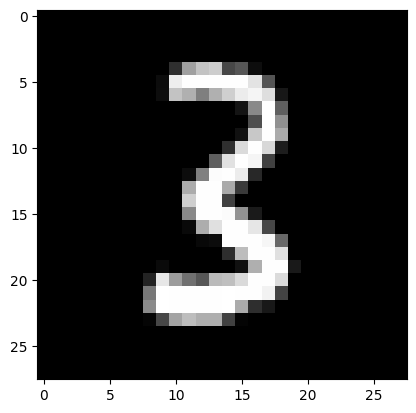

In [48]:
pyplot.imshow(x_valid[0].reshape((28, 28)), cmap="gray")
print(y_valid[0])